### Optimización continua utilizando algoritmo genético

Funciones a optimizar: <br/>
- <a href = https://www.sfu.ca/~ssurjano/spheref.html> Sphere Function </a>
- <a href = https://www.sfu.ca/~ssurjano/drop.html> Drop-Wave function </a>
- <a href = https://www.sfu.ca/~ssurjano/ackley.html> Ackley function </a>

In [1]:
import numpy as np
import math
import matplotlib.pylab as plt

Las 3 funciones se multiplican por un signo menos para convertir el problema de minimización en un problema de maximización.

In [2]:
def sphere_function(x):
    # funcion en R^d
    d = x.size 
    fx = 0.0
    for i in range(d):
        fx += x[i]**2
        
    return -fx  

In [3]:
def dropWave_function(x):
    # funcion en R^2
    fx = -(1+math.cos(12.0*(x[0]**2+x[1]**2)**0.5))
    fx = fx/(0.5*(x[0]**2+x[1]**2)+2)
    return -fx

In [4]:
def ackley_function(x, a=20, b=0.2, c=2*math.pi):
    # funcion en R^d
    d = x.size 
    aux = 0.0
    for i in range(d):
        aux += math.cos(c*x[i])
        
    fx = -a*math.exp(-b*(-sphere_function(x)/d)**0.5)-math.exp(aux/d)
    fx += a + math.exp(1)
    
    return -fx

### Función de decodificación

Se pasan como argumentos el individuo $a$, el número de bits $l_x$ para decodificar $x_i$, y los vectores $u=(u_1, \ldots, u_d)$, $v=(v_1, \ldots, v_d)$ que definen el dominio $[u_1, v_1]\times \dots \times [u_d, v_d]$ de la función `fitness` a maximizar. Devuelve el vector $x=(x_1,\ldots, x_d)\in [u_1, v_1]\times \dots \times [u_d, v_d]$ que representa el individuo $a$.

In [5]:
def sigma(a, lx, u, v):
    aux = 0.0
    x = []
    
    for i in range(d):
        for j in range(lx):
            aux += a[(i+1)*lx-1-j]*2**j
        
        xi = u[i] +(v[i]-u[i])/(2**lx-1)*aux
        x.append(xi)
    
    return np.array(x)

### Evaluación

Función para evaluar la población $P$ de $N$ individuos de acuerdo a la función `fitness`.

In [6]:
def evaluate(P, N, lx, u, v, fitness):
    ranking = []
    for i in range(N):
        x = sigma(P[i], lx, u, v)
        ranking.append(fitness(x))
        
    return ranking

### Operador de selección: Torneo binario

`P` es la población de individuos de tamaño $N$. `ranking` es el arreglo del fitness de cada individuo ya precalculado anteriormente. `mu` es el número de ganadores del torneo a escoger. 

In [7]:
def selectionOperator(P, ranking, N, mu): 
    # 2*mu es el numero de torneos binarios, por lo que habra mu ganadores
    # regresa los indices de los individuos en P seleccionados
    
    randomIndex = np.random.choice(N, 2*mu, replace=True)
    winners = []
        
    k=0
    while 2*k+1 < 2*mu:
        i1 = randomIndex[2*k]
        i2 = randomIndex[2*k+1]
    
        i1_fitness = ranking[i1]
        i2_fitness = ranking[i2]

        if i1_fitness > i2_fitness:
            winners.append(i1)
        else:
            winners.append(i2)
        k += 1
            
    return winners

### Operador de cruza
Cruza en dos puntos. `numVars` es igual a $d\cdot lx$.

In [8]:
def crossoverOperator(S, numVars, mu):
    # S es la poblacion seleccionada de P a traves del operador de seleccion
    # mu es el numero de padres a cruzar, el tamaño de S
    # La cruza se hace en S mismo para optimizar
    
    randomIndex = np.random.choice(mu, mu, replace=False)
    
    i=0
    while 2*i+1<mu :
        i1 = randomIndex[2*i]
        i2 = randomIndex[2*i+1]
        
        # 2 puntos de crossover
        crossPoints = np.random.choice(range(1,numVars-1), 2, replace=False)
        crossPoints.sort()
        
        # Cruza de S[i1] con S[i2]
        offspring1 = S[i1]
        offspring2 = S[i2]
            
        for k in range(numVars):
            if k>=crossPoints[0] and k<=crossPoints[1]: # intercambio de bits de los individuos entre los puntos de cruza
                aux = offspring1[k]
                offspring1[k] = offspring2[k]
                offspring2[k] = aux
        
        i += 1

### Operador de mutación
Mutación uniforme

In [9]:
def uniformMutationOperator(C, numVars, p):
    # C es el conjunto de individuos obtenidos al aplicar el operador de cruza
    # p es la probabilidad de mutacion
    # La mutacion dentro de C para optimizar
    
    for i in range(len(C)):
        for j in range(numVars):
            if np.random.uniform() <= p:
                C[i][j] = not C[i][j]

### Algoritmo Genético

Función para maximizar la función fitness $d$-dimensional definida en el compacto $[u_1, v_1]\times ... \times [u_d, v_d]$. Se pasan como argumentos la función `fitness`, la dimensión $d$, el tamaño $l_x$ para representar cada variable $x_i$, los vectores $u=(u_1, \ldots, u_d)$, $v=(v_1, \ldots, v_d)$ que definen el dominio, el tamaño de la población $N$ constante en cada generación, el porcentaje del elitismo `elite_percent`, y el número máximo de iteraciones `maxIter`.

In [10]:
def maximize(fitness, d, lx, u, v, N=100, elite_percent=0.1, maxIter=100):
    
    mu = int((1-elite_percent)*N) # complemento del porcentaje de la elite
    numVariables = d*lx
    prob_mutation = 1.0/numVariables
    
    # Poblacion inicial de tamaño N con distribucion uniforme
    P = []
    for i in range(N):
        P.append(np.random.choice([0, 1], numVariables, replace=True))
    
    best_fitness = []
        
    for t in range(maxIter):
        # Evaluacion de P
        ranking = evaluate(P, N, lx, u, v, fitness)
        
        fit = [(ranking[i],i) for i in range(N)]
        fit.sort(reverse=True)
        elite = fit[:int(len(P)*elite_percent)]
        print('Generacion: ' + str(t) + ' - Mejor fitness de P: ' + str(elite[0][0]) + " - Indice " + str(elite[0][1]))
        
        best_fitness.append(elite[0][0])
        
        # Seleccion por torneo binario
        winners = selectionOperator(P, ranking, N, mu)

        P2 = []
        for i in range(len(winners)):
            P2.append(np.copy(P[winners[i]]))

        # Cruza
        crossoverOperator(P2, numVariables, mu)

        # Mutation
        uniformMutationOperator(P2, numVariables, prob_mutation)

        # Reemplazo 
        for i in range(len(elite)):
            P2.append(np.copy(P[elite[i][1]]))
            
        P = P2
        
    # Obtener el maximo fitness de la ultima generacion
        
    maxFit = float('-inf') 
    maxIndex = 0

    for i in range(N):
        aux = fitness(sigma(P[i], lx, u, v))
        if aux > maxFit:
            maxFit = aux
            maxIndex = i
    best_fitness.append(maxFit)
    
    print('Generacion: ' + str(maxIter) + ' - Mejor fitness de P: ' + str(maxFit) + " - Indice " + str(maxIndex))
        
    return sigma(P[maxIndex], lx, u, v), best_fitness

### Minimizando la sphere function

In [11]:
d = 2
u = np.array([-5.12 for i in range(d)])
v = np.array([5.12 for i in range(d)])
lx = 50
maxIter = 100

In [12]:
x_star, best_fitness = maximize(sphere_function, d, lx, u, v, maxIter = maxIter)
x_star

Generacion: 0 - Mejor fitness de P: -0.4118581599033254 - Indice 38
Generacion: 1 - Mejor fitness de P: -0.4118581599033254 - Indice 90
Generacion: 2 - Mejor fitness de P: -0.18332493037886857 - Indice 48
Generacion: 3 - Mejor fitness de P: -0.18332493037886857 - Indice 90
Generacion: 4 - Mejor fitness de P: -0.033672484719828116 - Indice 72
Generacion: 5 - Mejor fitness de P: -0.006028608467442316 - Indice 62
Generacion: 6 - Mejor fitness de P: -0.006028608467442316 - Indice 90
Generacion: 7 - Mejor fitness de P: -0.005966547612252356 - Indice 36
Generacion: 8 - Mejor fitness de P: -0.004682166282574378 - Indice 76
Generacion: 9 - Mejor fitness de P: -0.0012825688844066896 - Indice 79
Generacion: 10 - Mejor fitness de P: -0.0012796165273660967 - Indice 76
Generacion: 11 - Mejor fitness de P: -0.000507529555153044 - Indice 8
Generacion: 12 - Mejor fitness de P: -0.0003694496641771927 - Indice 59
Generacion: 13 - Mejor fitness de P: -0.0003694496641771927 - Indice 90
Generacion: 14 - Me

array([-2.32413681e-07, -5.69661420e-08])

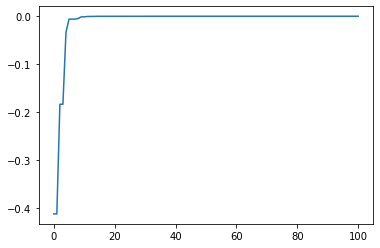

In [13]:
plt.plot(range(maxIter+1), best_fitness)
plt.show()

### Minimizando la drop-wave function

In [14]:
d = 2
u = np.array([-5.12 for i in range(d)])
v = np.array([5.12 for i in range(d)])
lx = 10
maxIter = 100

In [15]:
x_star, best_fitness = maximize(dropWave_function, d, lx, u, v, maxIter = maxIter)
x_star

Generacion: 0 - Mejor fitness de P: 0.7310091314393359 - Indice 2
Generacion: 1 - Mejor fitness de P: 0.7310091314393359 - Indice 90
Generacion: 2 - Mejor fitness de P: 0.7338201605396897 - Indice 1
Generacion: 3 - Mejor fitness de P: 0.9361377897035548 - Indice 53
Generacion: 4 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 5 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 6 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 7 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 8 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 9 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 10 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 11 - Mejor fitness de P: 0.9361377897035548 - Indice 90
Generacion: 12 - Mejor fitness de P: 0.9361878175407568 - Indice 80
Generacion: 13 - Mejor fitness de P: 0.9361878175407568 - Indice 90
Generacion: 14 - Mejor fitness de P: 0.9361878175407568 - In

array([-0.03503421,  0.00500489])

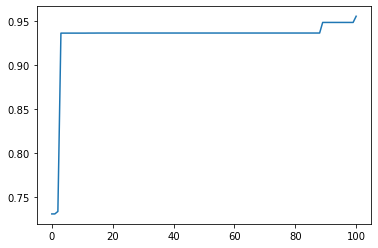

In [16]:
plt.plot(range(maxIter+1), best_fitness)
plt.show()

### Minimizando la Ackley function

In [17]:
d = 2
u = np.array([-5.12 for i in range(d)])
v = np.array([5.12 for i in range(d)])
lx = 10
maxIter = 100

In [18]:
x_star, best_fitness = maximize(ackley_function, d, lx, u, v, maxIter = maxIter)
x_star

Generacion: 0 - Mejor fitness de P: -2.5322785752692702 - Indice 99
Generacion: 1 - Mejor fitness de P: -2.5322785752692702 - Indice 90
Generacion: 2 - Mejor fitness de P: -2.5322785752692702 - Indice 90
Generacion: 3 - Mejor fitness de P: -1.4529445049219625 - Indice 44
Generacion: 4 - Mejor fitness de P: -1.3370985896447678 - Indice 87
Generacion: 5 - Mejor fitness de P: -0.4254674905527729 - Indice 51
Generacion: 6 - Mejor fitness de P: -0.4254674905527729 - Indice 90
Generacion: 7 - Mejor fitness de P: -0.4254674905527729 - Indice 90
Generacion: 8 - Mejor fitness de P: -0.4254674905527729 - Indice 90
Generacion: 9 - Mejor fitness de P: -0.4254674905527729 - Indice 90
Generacion: 10 - Mejor fitness de P: -0.18197348280865455 - Indice 63
Generacion: 11 - Mejor fitness de P: -0.10508683694749266 - Indice 14
Generacion: 12 - Mejor fitness de P: -0.05142239688355943 - Indice 67
Generacion: 13 - Mejor fitness de P: -0.05142239688355943 - Indice 90
Generacion: 14 - Mejor fitness de P: -0.

array([-0.00500489, -0.00500489])

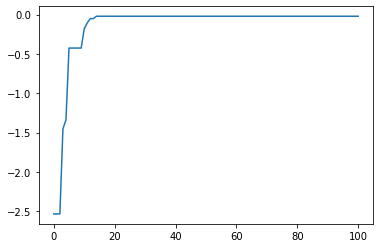

In [19]:
plt.plot(range(maxIter+1), best_fitness)
plt.show()